In [3]:
import numpy as np
import pandas as pd

In [4]:
import activation
class TwoLayerNet:    
    """    
    一个二层的全连接网络 输入层的维度为D, 隐藏层维度为 H, 类别为C类.    
       
    input - fully connected layer - ReLU - fully connected layer - softmax
    第二个全连接层的输出为分数
    """
    def __init__(self, input_size, hidden_size, output_size, std=1e-4): 
        """    
         
        W1:  (D, H)    
        b1:  (H,)    
        W2:  (H, C)    
        b2:  (C,)  
        """    
        self.params = {}    
        self.params['W1'] = std * np.random.randn(hidden_size, input_size)   
        self.params['b1'] = np.random.randn(hidden_size, 1)   
        self.params['W2'] = std * np.random.randn(output_size, hidden_size)   
        self.params['b2'] = np.random.randn(output_size, 1)
        self.weights = [np.array([0])] + [self.params['W1']]+[self.params['W2']]
        self.biases = [np.array([0])] + [self.params['b1']]+[self.params['b2']]
        self.nuerons = [np.zeros(bias.shape) for bias in self.biases]
        self.linear = [np.zeros(bias.shape) for bias in self.biases]
        
    def fc_backward(next_dz, W, z):
        """
        全连接层的反向传播
        :param next_dz: 下一层的梯度
        :param W: 当前层的权重
        :param z: 当前层的输出
        :return:
        """
        N = z.shape[0]
        dz = np.dot(next_dz, W.T)  # 当前层的梯度
        dw = np.dot(z.T, next_dz)  # 当前层权重的梯度
        db = np.sum(next_dz, axis=0)  # 当前层偏置的梯度, N个样本的梯度求和
        return dw / N, db / N, dz

    def forward(self,input):
        self.nuerons[0] = input
        for i in range(1,3):
            self.linear[i] = self.weights[i].dot(self.nuerons[i-1]) + self.biases[i]

            # 加入激活函数
            if i == 2:
                self.nuerons[i] = activation.softmax(self.linear[i])
            else:
                self.nuerons[i] = activation.relu(self.linear[i])
        return self.nuerons[2]

    def cross_entropy_loss(self,y_predict, y_true):
        y_shift = y_predict - np.max(y_predict, axis=-1, keepdims=True)
        y_exp = np.exp(y_shift)
        y_probability = y_exp / np.sum(y_exp, axis=-1,keepdims=True)
        data_loss = np.mean(np.sum(y_true * (-np.log(y_probability)), axis=-1))  # 损失函数
        return data_loss,y_probability
        
    def backward(self, loss_gradient):
        nabla_b = [np.zeros(bias.shape) for bias in self.biases]
        nabla_w = [np.zeros(weight.shape) for weight in self.weights]

        nabla_b[-1] = loss_gradient
        nabla_w[-1] = loss_gradient.dot(self.nuerons[-2].transpose())

        for layer in range(1, 0, -1):
            loss_gradient = np.multiply(
                self.weights[layer+1].transpose().dot(loss_gradient),
                activation.relu_gradient(self.linear[layer])
            )
            nabla_b[layer] = loss_gradient
            nabla_w[layer] = loss_gradient.dot(self.nuerons[layer-1].transpose())
        
        return nabla_b, nabla_w

    def loss(self, X, y=None, reg=0.0):
        
        
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # 前向传播
        scores = None
        h1 = ReLU(np.dot(X, W1) + b1)      # 隐藏层  (N,H)
        out = np.dot(h1, W2) + b2          # 输出层  (N,C)
        scores = out                       # (N,C)  
        if y is None:   
            return scores

       
        scores_max = np.max(scores, axis=1, keepdims=True)    # (N,1)
        
        exp_scores = np.exp(scores - scores_max)              # (N,C)
        # probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)    # (N,C)
        
        probs = exp_scores / np.sum(exp_scores, axis=-1,keepdims=True)
        data_loss = -np.mean(np.sum(y * np.log(probs + 1e-5), axis=-1))

        # correct_logprobs = -np.log(probs)        # (N,1)
        # data_loss = np.sum(correct_logprobs) / N
        reg_loss = 0.5 * reg * np.sum(W1*W1) + 0.5 * reg * np.sum(W2*W2)
        loss = data_loss + reg_loss

        # 反向传播
        grads = {}
       
        dscores = probs                                 # (N,C)
        dscores -= 1
        dscores /= N
    
        dW2 = np.dot(h1.T, dscores)                     # (H,C)
        db2 = np.sum(dscores, axis=0, keepdims=True)    # (1,C)
       
        dh1 = np.dot(dscores, W2.T)                     # (N,H)
        # ReLu层
        dh1[h1 <= 0] = 0
        
        dW1 = np.dot(X.T, dh1)                          # (D,H)
        db1 = np.sum(dh1, axis=0, keepdims=True)        # (1,H)
       
        dW2 += reg * W2
        dW1 += reg * W1
        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2

        return loss, grads

    

    def train(self, X, y, X_val, y_val, learning_rate=1e-3, 
               learning_rate_decay=0.95, reg=1e-5, mu=0.9, num_epochs=10, 
               mu_increase=1.0, batch_size=200, verbose=False):   
        """    
        还是使用SGD 
        Inputs:    
        - X:  (N, D)    
        - y:(N,) 
        - X_val:  (N_val, D)     
        - y_val:  (N_val,)     
        - learning_rate:     
        - learning_rate_decay:   学习率衰减因子
        - reg:    
        - num_iters:    
        - batch_size:     
        - verbose: boolean; if true print progress during optimization.  
        """
        num_train = len(X)
        iterations_per_epoch = max(num_train / batch_size, 1)
        
        v_W2, v_b2 = 0.0, 0.0
        v_W1, v_b1 = 0.0, 0.0
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in tqdm(range(1, int(num_epochs * iterations_per_epoch) + 1)):   
            X_batch = None   
            y_batch = None    
               
            sample_index = np.random.choice(num_train, batch_size, replace=True)   
            X_batch = X[sample_index, :]        # (batch_size,D)    
            y_batch = y[sample_index]           # (1,batch_size)   
            
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg) 
            loss_history.append(loss)    

            # SGD结合向量    
            v_W2 = mu * v_W2 - learning_rate * grads['W2']    
            self.params['W2'] += v_W2   
            v_b2 = mu * v_b2 - learning_rate * grads['b2']    
            self.params['b2'] += v_b2   
            v_W1 = mu * v_W1 - learning_rate * grads['W1']    
            self.params['W1'] += v_W1   
            v_b1 = mu * v_b1 - learning_rate * grads['b1']  
            self.params['b1'] += v_b1 
            # iteration %d / %d: loss %f' % (it, num_iters, loss) 
         
            # 每一个epoch, 检查 train and val 准确率 然后将学习率衰减
            #每次取X_batch个数据，每取够X_train的数量为一个epoch，然后将学习率衰减
            if verbose and it % iterations_per_epoch == 0:    
                res_train = []
                res_valid = []
                
                # for i in range(y_batch.shape[0]):
                    
                #     epoch = it / iterations_per_epoch    
                #     if self.predict(X_batch).tolist()[i] == y_batch.tolist()[i]:
                #         res_train.append(1)
                #     else:
                #         res_train.append(0)
                    
                #     if self.predict(X_val).tolist()[i] == y_val.tolist()[i]:
                #         res_valid.append(1)
                #     else:
                #         res_valid.append(0)
                # train_acc = np.mean(res_train)        
                # val_acc = np.mean(res_valid)
                print(self.predict(X_batch) == y_batch)
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean() 
                train_acc_history.append(train_acc)    
                val_acc_history.append(val_acc)    
                # print 'epoch %d / %d: loss %f, train_acc: %f, val_acc: %f' % 
                #                     (epoch, num_epochs, loss, train_acc, val_acc)    
                
                learning_rate *= learning_rate_decay    
                #mu也要变化   
                mu *= mu_increase
                print(res_train)
        return {   
            'loss_history': loss_history,   
            'train_acc_history': train_acc_history, 
            'val_acc_history': val_acc_history,},val_acc
        

    def predict(self, X):    
      
        y_pred = None    
        h1 = ReLU(np.dot(X, self.params['W1']) + self.params['b1'])    
        scores = np.dot(h1, self.params['W2']) + self.params['b2']    
        y_pred = np.argmax(scores, axis=1)    

        return y_pred

def ReLU(x):    
    return np.maximum(0, x)

In [5]:
class SGD:
    
    def __init__(self, model, learning_rate, weight_decay, batch_size):
        self.model = model
        self.lr = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size

        self.nabla_b = [np.zeros(bias.shape) for bias in self.model.biases]
        self.nabla_w = [np.zeros(weight.shape) for weight in self.model.weights]

    def zero_grad(self):
        self.nabla_b = [np.zeros(bias.shape) for bias in self.model.biases]
        self.nabla_w = [np.zeros(weight.shape) for weight in self.model.weights]

    def update(self, delta_nabla_b, delta_nabla_w):
        self.nabla_b = [nb + dnb for nb, dnb in zip(self.nabla_b, delta_nabla_b)]
        self.nabla_w = [nw + dnw for nw, dnw in zip(self.nabla_w, delta_nabla_w)]

    def step(self):
        # 参数更新
        # 使用batch gradient descent，因此学习率要除以batch_size
        self.model.weights = [(1 - self.lr * self.weight_decay) * w - (self.lr / self.batch_size) * dw for w, dw in zip(self.model.weights, self.nabla_w)]
        self.model.biases = [(1 - self.lr * self.weight_decay) * b - (self.lr / self.batch_size) * db for b, db in zip(self.model.biases, self.nabla_b)]

In [6]:
from utils import load_mnist_datasets
from imp import reload
train_data,val_data,test_data = load_mnist_datasets('data/mnist.pkl.gz')


C:\Users\chuch\AppData\Local\Temp\ipykernel_54924\1606908391.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [9]:
import random
import os
def train_reset(net, optimizer, train_data, val_data, epochs):
    best_accuracy = 0
    train_losses = []
    validate_losses = []
    accuracies = []
    for epoch in range(epochs):
        # validate
        validate_loss = 0
        res = []
        for input, label in val_data:
            output = net.forward(input)
            validate_loss += np.where(label==1, -np.log(output), 0).sum()
            res.append(np.argmax(output) == np.argmax(label))
        validate_loss /= len(val_data)
        validate_losses.append(validate_loss)
        accuracy = sum(res) / 100.0
        accuracies.append(accuracy)
        # train
        random.shuffle(train_data)
        batches = [train_data[k:k+optimizer.batch_size] for k in range(0, len(train_data), optimizer.batch_size)]
        train_loss = 0
        for batch in batches:
            optimizer.zero_grad()
            for input, label in batch:
                output = net.forward(input)
                # loss为交叉熵损失函数
                train_loss  += np.where(label==1, -np.log(output), 0).sum()
                # cross entropy loss + softmax 的导数
                loss_gradient = output - label
                delta_nabla_b, delta_nabla_w = net.backward(loss_gradient)
                optimizer.update(delta_nabla_b, delta_nabla_w)
            optimizer.step()
        train_loss /= len(train_data)
        train_losses.append(train_loss)
        # save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            with open(os.path.join("models",f"lr{optimizer.lr}_weight_decay{optimizer.weight_decay}.npz"),"w",encoding="utf-8") as f:
                f.write(f"net.weights:{net.weights},net.biases:{net.biases},net.linear:{net.linear},net.nuerons:{net.nuerons}")
            # net.save(f"model_{net.sizes[1]}_{optimizer.lr}_{optimizer.weight_decay}.npz")
        print(f"Epoch {epoch+1}, accuracy {accuracy} %.")
    # save log
    data = {
        "train_loss": train_losses,
        "val_loss": validate_losses,
        "val_acc": accuracies
    }
    # pd.DataFrame(data).to_csv(f'logs/log_{model.sizes[1]}_{optimizer.lr}_{optimizer.weight_decay}.csv',)
    return best_accuracy,data

In [40]:
#使用验证集进行调参 将最好的模型存储到best_net
import utils
from tqdm import tqdm

input_size = 28 * 28 
hidden_size = 50
num_classes = 10

results = {}
best_val = -1
best_net = None

learning_rates = [5e-3, 1e-2, 2e-2]
weight_decay = [0.001,0.01,0.1]
epochs = 30
batch_size = 16

for j in tqdm(range(len(learning_rates))):
    lr = learning_rates[j]
    for reg in weight_decay:
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        optimizer = SGD(net, lr, reg, batch_size)
        # 训练train_data
        val_acc,data = train_reset(net, optimizer, train_data, val_data, epochs)
        
        if val_acc > best_val:
            best_val = val_acc
            best_net = net
            result_loss_acc = data
        results[(lr,reg)] = val_acc

# 打印结果
for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (
                lr, reg,  val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, accuracy 9.67 %.
Epoch 2, accuracy 39.39 %.
Epoch 3, accuracy 84.79 %.
Epoch 4, accuracy 88.88 %.
Epoch 5, accuracy 90.26 %.
Epoch 6, accuracy 91.22 %.
Epoch 7, accuracy 91.89 %.


In [ ]:
# test
model = best_net
record = []
for data,label in test_data:
    output = model.forward(data)
    record.append(np.argmax(output) == np.argmax(label))
test_accuracy = sum(record) / len(record)
print(f"test accuracy: {test_accuracy} %")

test accuracy: 0.9653 %


In [ ]:
result_loss_acc1 = pd.DataFrame(result_loss_acc)

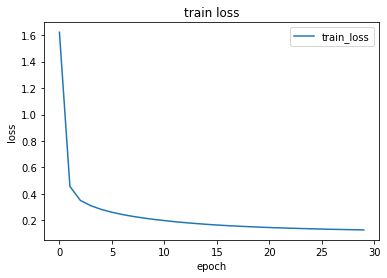

In [ ]:
# visualization
# 可视化loss曲线
import matplotlib.pyplot as plt
result_loss_acc1[['train_loss']].plot(title='train loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("visual/train_loss.png")
plt.show()
plt.close()

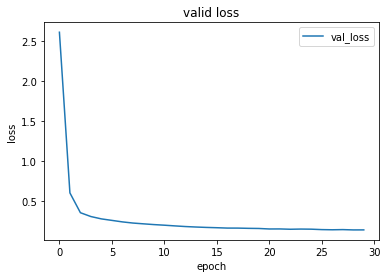

In [ ]:
result_loss_acc1[['val_loss']].plot(title='valid loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("visual/train_loss.png")
plt.show()
plt.close()

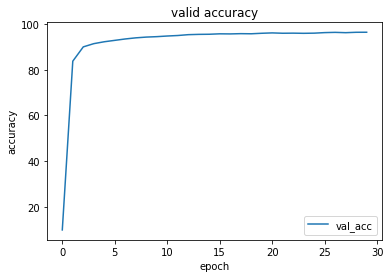

In [ ]:
#可视化accuracy
result_loss_acc1[['val_acc']].plot(title='valid accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("visual/accuracy.png")
plt.show()
plt.close()

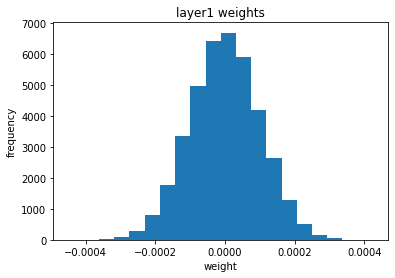

In [ ]:
plt.hist(net.params['W1'].flatten().tolist(), bins=20)
plt.title("layer1 weights")
plt.xlabel("weight")
plt.ylabel("frequency")
plt.savefig("visual/layer1_weights.png")
plt.show()
plt.close()

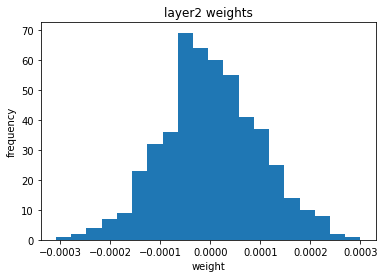

In [ ]:
plt.hist(net.params['W2'].flatten().tolist(), bins=20)
plt.title("layer2 weights")
plt.xlabel("weight")
plt.ylabel("frequency")
plt.savefig("visual/layer2_weights.png")
plt.show()
plt.close()

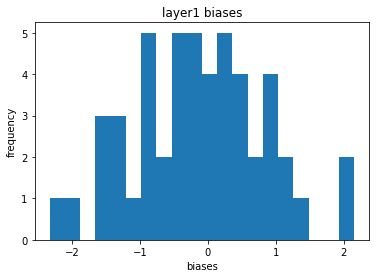

In [ ]:
plt.hist(net.params['b1'].flatten().tolist(), bins=20)
plt.title("layer1 biases")
plt.xlabel("biases")
plt.ylabel("frequency")
plt.savefig("visual/layer1_weights.png")
plt.show()
plt.close()

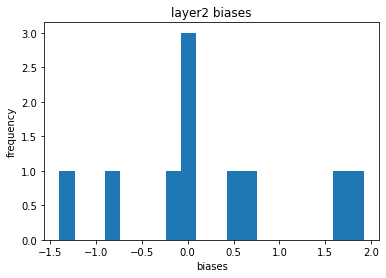

In [ ]:
plt.hist(net.params['b2'].flatten().tolist(), bins=20)
plt.title("layer2 biases")
plt.xlabel("biases")
plt.ylabel("frequency")
plt.savefig("visual/layer1_weights.png")
plt.show()
plt.close()